## Practice Case Time Series

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import warnings

## Import Dataset

- Sales contains the quarterly sales for a small company over the period 1981–2005. AdBudget is the advertising budget and GDP is the gross domestic product. All series have been adjusted for inflation.

- Objective : Forecast Sales untuk 3 Kuartal Kedepan

In [2]:
df_ori = pd.read_csv('tute1.csv')

## Sneak Peak to Data

In [3]:
df_ori.head()

,Unnamed: 0,Sales,AdBudget,GDP
0,Mar-81,1020.2,659.2,251.8
1,Jun-81,889.2,589.0,290.9
2,Sep-81,795.0,512.5,290.8
3,Dec-81,1003.9,614.1,292.4
4,Mar-82,1057.7,647.2,279.1


In [4]:
df_ori.rename(columns={
    'Unnamed: 0':'Date'
}, inplace=True)

In [5]:
df_ori = df_ori.drop(columns=['AdBudget', 'GDP'])

In [6]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
Date     100 non-null object
Sales    100 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [7]:
df_ori.shape

(100, 2)

In [8]:
df_ori.describe()

,Sales
count,100.000000
mean,948.737000
std,98.252187
min,735.100000
25%,871.100000
50%,960.650000
75%,1018.700000
max,1115.500000


In [9]:
df_ori.head()

,Date,Sales
0,Mar-81,1020.2
1,Jun-81,889.2
2,Sep-81,795.0
3,Dec-81,1003.9
4,Mar-82,1057.7


## Convert to Datetime

In [10]:
#Menggunakan Regex untuk mengganti nama bulan menjadi angka
df_ori['Date'] = df_ori['Date'].replace(r'^Mar', '03', regex=True).replace(r'^Jun', '06', regex=True).replace(r'^Sep', '09', regex=True).replace(r'^Dec', '12', regex=True)

In [11]:
#Menambahkan hari yaitu dibuat default ke tanggal 01
df_ori['Date']  = '01-' + df_ori['Date']

In [12]:
#Mengubah menjadi Datetime
df_ori['Date']  = pd.to_datetime(df_ori['Date'],dayfirst=True)

In [13]:
#Menjadikan kolom date menjadi index
df_ori.set_index(df_ori['Date'], inplace=True)
df_ori.drop(columns=['Date'], inplace=True)
df_ori.head()

,Sales
Date,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7


## Handling Missing Values

In [14]:
df_ori.isnull().sum()

Sales    0
dtype: int64

- Tidak ditemukan missing values, jadi bisa lanjut ke proses berikutnya

## Data Understanding

In [15]:
df_ori.head()

,Sales
Date,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7


In [16]:
df_ori.tail()

,Sales
Date,
2004-12-01,1018.7
2005-03-01,1112.5
2005-06-01,997.4
2005-09-01,826.8
2005-12-01,992.6


### Check the Seasonality

F:\Anaconda\envs\pandas\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


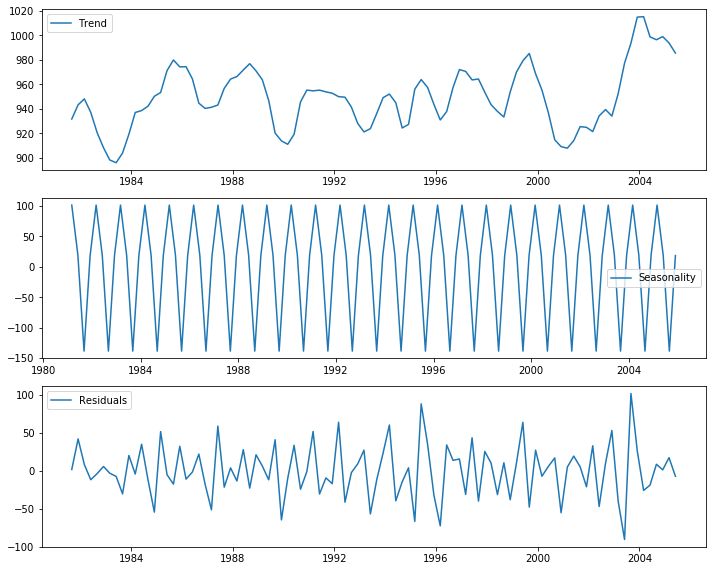

In [17]:
decomposition = seasonal_decompose(df_ori['Sales'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Data tidak memiliki trend
- Data memiliki komponen musiman, maka dari itu dalam penyelesain kasus ini saya akan menggunakan model ARIMA dan SARIMA untuk membandingkan kedua model tersebut

### Check the Stationarity

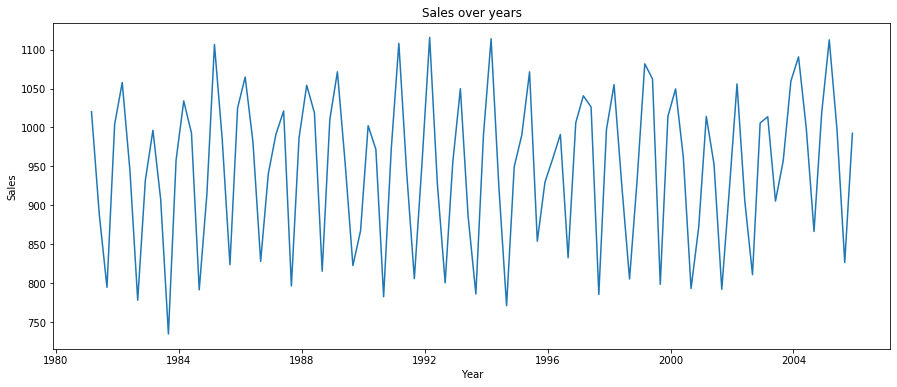

In [18]:
plt.figure(figsize=(15,6))
plt.plot(df_ori)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales over years')
plt.show()

In [19]:
#Rolling statistics
roll_mean = df_ori.rolling(window=4).mean()
roll_std = df_ori.rolling(window=4).std()
print(roll_mean.head())
print(roll_std.head())

              Sales
Date               
1981-03-01      NaN
1981-06-01      NaN
1981-09-01      NaN
1981-12-01  927.075
1982-03-01  936.450
                 Sales
Date                  
1981-03-01         NaN
1981-06-01         NaN
1981-09-01         NaN
1981-12-01  105.597771
1982-03-01  117.603472


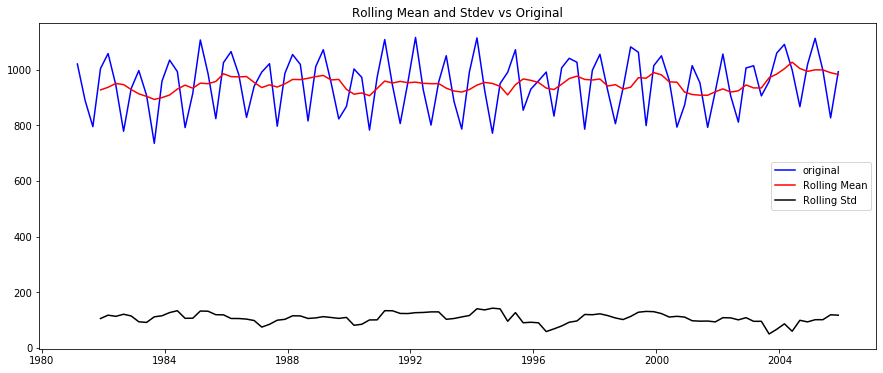

In [20]:
plt.figure(figsize=(15,6))
plt.plot(df_ori['Sales'], color='blue', label='original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label='Rolling Std')
plt.title('Rolling Mean and Stdev vs Original')
plt.legend()

Secara kasat mata, dataset sudah stasioner. Untuk memastikan kita cek menggunakan Dicky Fuller

In [21]:
adftest = adfuller(df_ori['Sales'], autolag='AIC')

In [22]:
adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
adf_output

Test Statistic                 -3.262755
p-value                         0.016628
#Lags Used                      9.000000
Number of Observations Used    90.000000
dtype: float64

- Karena nilai p-value kurang dari 0.05 maka, H0 ditolak yaitu data sudah stasioner
- Sudah bisa dilanjutkan ke tahap modelling

## First Modelling with ARIMA

In [23]:
df_ori.head()

,Sales
Date,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7


### Search p, d, and q

Karena tadi tidak melakukan differencing maka nilai d adalah 0

untuk mencari nilai p, kita melihat dari pacf. Dari grafik pacf dapat dilihat bahwa cut off nya berada pada lag ke 4

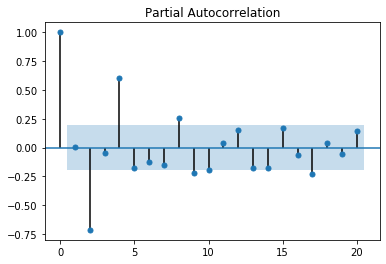

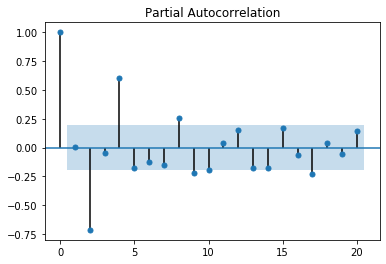

In [24]:
plot_pacf(df_ori, lags=20)

untuk mencari nilai q, kita melihat dari acf. Dari grafik acf dapat dilihat bahwa polanya ternyata adalah seasonal, maka nilai 1 adalah 0

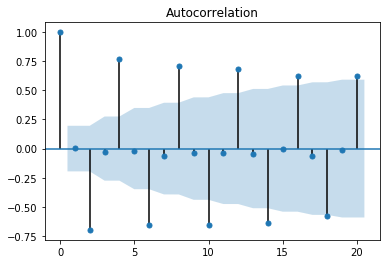

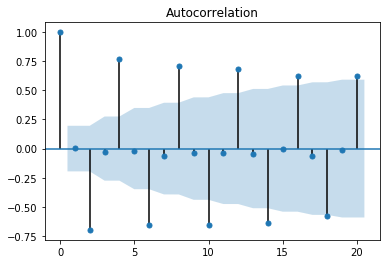

In [25]:
plot_acf(df_ori, lags=20)

### Split data to Training and Testing set

In [26]:
train_size = int(len(df_ori)*0.8)
train_size

80

In [27]:
train = df_ori[0:train_size]
test = df_ori[train_size:]
print(train.shape)
print(test.shape)

(80, 1)
(20, 1)


### Modelling

In [28]:
arima_order = (4,0,0)
arima = ARIMA(train, order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

F:\Anaconda\envs\pandas\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   80
Model:                     ARMA(4, 0)   Log Likelihood                -433.396
Method:                       css-mle   S.D. of innovations             53.406
Date:                Thu, 05 Sep 2019   AIC                            878.792
Time:                        21:24:38   BIC                            893.084
Sample:                    03-01-1981   HQIC                           884.522
                         - 12-01-2000                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         944.9071      5.885    160.556      0.000     933.372     956.442
ar.L1.Sales    -0.0806      0.093     -0.868      0.388      -0.263       0.101
ar.L2.Sales    -0.3382      0.090     -3.746    

In [29]:
#Plotting the model residual
p = arima_fit.predict()
df_train = pd.DataFrame(p, columns=['prediksi'])
df_train['actual'] = train.values
df_train.head()

,prediksi,actual
1981-03-01,944.907134,1020.2
1981-06-01,943.646802,889.2
1981-09-01,890.351296,795.0
1981-12-01,1000.928971,1003.9
1982-03-01,1040.112555,1057.7


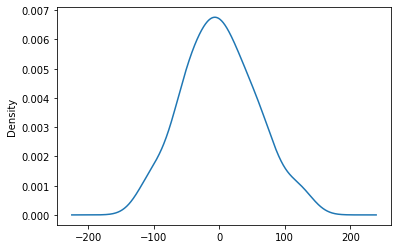

In [30]:
#Showing the distribution
residual = df_train['actual'] - df_train['prediksi']
residual.plot(kind='kde')
plt.show()

- Dapat dilihat ternyata ditribusi dari residual rata-rata berada di 0 dengan variance yang seragam. sehingga distribusinya sudah fine.

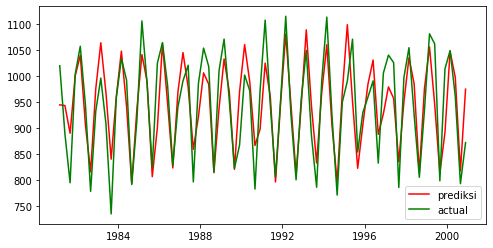

In [31]:
#Actual vs Forecasted in training dataset
plt.figure(figsize=(8,4))
plt.plot(df_train['prediksi'], color='red', label='prediksi')
plt.plot(df_train['actual'], color='green', label='actual')
plt.legend()
plt.show()

In [32]:
#Nilai prediksi dari model
y_pred = arima_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=['prediksi'], index=test.index)
df_test['actual'] = test.values
df_test.head()

,prediksi,actual
Date,,
2001-03-01,1057.334883,1014.2
2001-06-01,990.726757,952.6
2001-09-01,829.740767,792.4
2001-12-01,883.019802,922.3
2002-03-01,1044.467415,1055.9


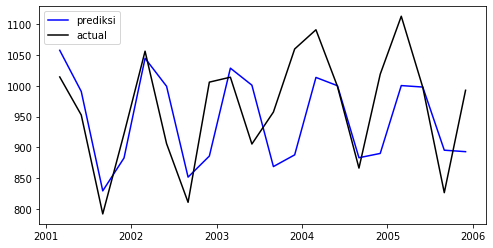

In [33]:
#Actual vs Forecasted in test dataset
plt.figure(figsize=(8,4))
plt.plot(df_test['prediksi'], color='blue', label='prediksi')
plt.plot(df_test['actual'], color='black', label='actual')
plt.legend()
plt.show()

In [34]:
#Menghitung nilai RMSE
mse = mean_squared_error(df_test['actual'], df_test['prediksi'])
f'Nilai dari RMSE adalah sebesar {sqrt(mse)}'

'Nilai dari RMSE adalah sebesar 79.81326641076477'

In [35]:
#Menghitung nilai MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(df_test['actual'], df_test['prediksi'])
f'Nilai dari MAPE adalah sebesar {mape}'

'Nilai dari MAPE adalah sebesar 6.652286725898585'

### Prediction for 3 Period

In [36]:
forecast = arima_fit.forecast(3)[0]
forecast = pd.DataFrame(forecast, columns=['Prediction'])
forecast

,Prediction
0,1057.334883
1,990.726757
2,829.740767


### Conslusion Metode ARIMA:
- Parameter metode ARIMA adalah (4,0,0)
- Nilai RMSE dari model ARIMA adalah sebesar 79.8
- Nilai MAPE dari model ARIMA adalah sebesar 6.52
- Hasil prediksi selama 3 periode untuk model ARIMA adalah:
    1. Periode kuartal 1 = 1057.33
    2. Periode kuartal 2 = 990.72
    3. Periode kuartal 3 = 829.74

## Second Modelling with SARIMA

### Split data to Training and Testing

In [37]:
train_size = int(len(df_ori)*0.8)
train_size

80

In [38]:
train = df_ori[0:train_size]
test = df_ori[train_size:]
print(train.shape)
print(test.shape)

(80, 1)
(20, 1)


### Find the best parameters for SARIMAX

In [39]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


In [40]:
warnings.filterwarnings("ignore")

In [41]:
aic = 999999
for parameter in pdq:
    for parameter_seasonal in seasonal_pdq:
        sarima_model = SARIMAX(train,
                               order=parameter,
                               seasonal_order=parameter_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False,)
        sarima_model_fit = sarima_model.fit()
        if aic > sarima_model_fit.aic:
            aic = sarima_model_fit.aic
print(f'SARIMA model terbaik adalah dengan parameter {parameter}x{parameter_seasonal}4 - dengan nilai AIC sebesar {aic}')

SARIMA model terbaik adalah dengan parameter (1, 1, 1)x(1, 1, 1, 4)4 - dengan nilai AIC sebesar 738.9219896959518


In [42]:
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 4),
                       enforce_stationarity=False,
                       enforce_invertibility=False,)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                   80
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -366.198
Date:                           Thu, 05 Sep 2019   AIC                            742.397
Time:                                   21:24:51   BIC                            753.568
Sample:                               03-01-1981   HQIC                           746.829
                                    - 12-01-2000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0692      0.148      0.468      0.640      -0.221       0.359
ma.L1         -1.0000    265.628     -0.004

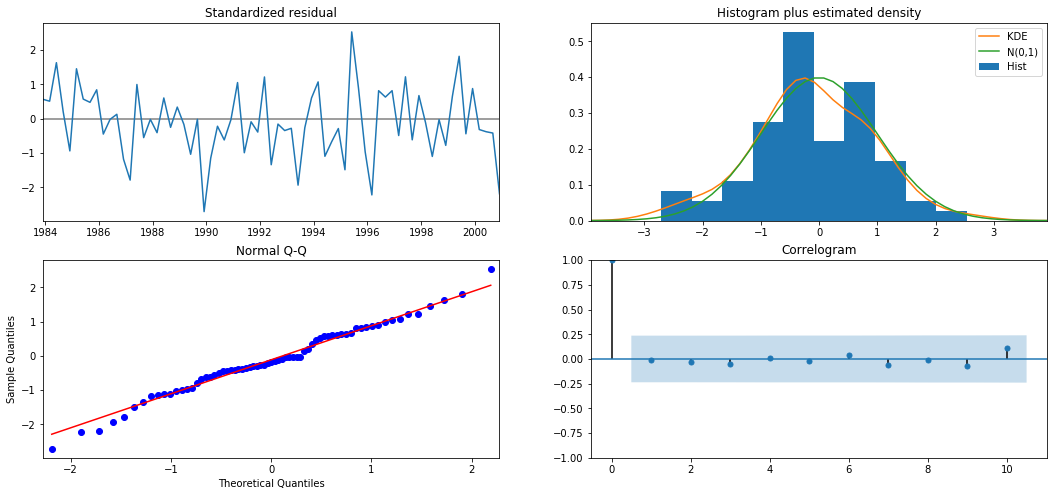

In [43]:
sarima_model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

In [44]:
#Plotting the model residual
p = sarima_model_fit.predict(start=1)
df_train_2 = pd.DataFrame(p, columns=['prediksi'])
df_train_2['actual'] = train.values[1:]
df_train_2.head()

,prediksi,actual
1981-06-01,1043.724623,889.2
1981-09-01,885.616043,795.0
1981-12-01,791.694495,1003.9
1982-03-01,1672.348817,1057.7
1982-06-01,904.845075,944.4


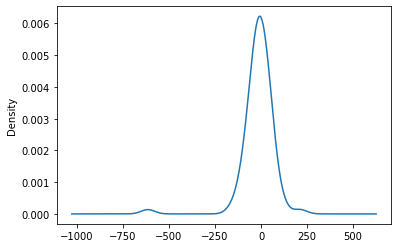

In [45]:
#Showing the distribution
residual_2 = df_train_2['actual'] - df_train_2['prediksi']
residual_2.plot(kind='kde')
plt.show()

- Dapat dilihat ternyata ditribusi dari residual rata-rata berada di 0 dengan variance yang kurang seragam dengan range yang berbeda di sisi kanan dan kiri.

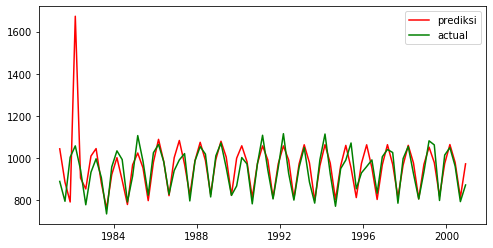

In [46]:
#Actual vs Forecasted in training dataset
plt.figure(figsize=(8,4))
plt.plot(df_train_2['prediksi'], color='red', label='prediksi')
plt.plot(df_train_2['actual'], color='green', label='actual')
plt.legend()
plt.show()

In [47]:
#Nilai prediksi dari model
y_pred_2 = sarima_model_fit.forecast(len(test))
df_test_2 = pd.DataFrame(y_pred_2, columns=['prediksi'], index=test.index)
df_test_2['actual'] = test.values
df_test_2.head()

,prediksi,actual
Date,,
2001-03-01,1050.593062,1014.2
2001-06-01,978.935439,952.6
2001-09-01,809.102687,792.4
2001-12-01,972.671483,922.3
2002-03-01,1057.712124,1055.9


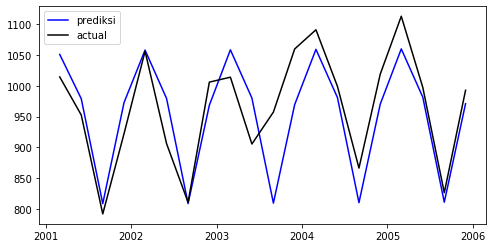

In [48]:
#Actual vs Forecasted in test dataset
plt.figure(figsize=(8,4))
plt.plot(df_test_2['prediksi'], color='blue', label='prediksi')
plt.plot(df_test_2['actual'], color='black', label='actual')
plt.legend()
plt.show()

In [49]:
#Menghitung nilai RMSE
mse = mean_squared_error(df_test_2['actual'], df_test_2['prediksi'])
f'Nilai dari RMSE adalah sebesar {sqrt(mse)}'

'Nilai dari RMSE adalah sebesar 54.54896105740146'

In [50]:
#Menghitung nilai MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(df_test_2['actual'], df_test_2['prediksi'])
f'Nilai dari MAPE adalah sebesar {mape}'

'Nilai dari MAPE adalah sebesar 4.448449025212869'

### Prediction for 3 Periods

In [51]:
forecast_2 = sarima_model_fit.forecast(3)
forecast_2 = pd.DataFrame(forecast_2, columns=['Prediction'])
forecast_2 = forecast_2.reset_index().drop(columns='index')
forecast_2

,Prediction
0,1050.593062
1,978.935439
2,809.102687


### Conslusion Metode SARIMA:
- Parameter metode SARIMA adalah (1,1,1)x(1,1,1,4)4 - dengan nilai AIC sebesar 738.9219896959518
- Nilai RMSE dari model SARIMA adalah sebesar 54.54
- Nilai MAPE dari model SARIMA adalah sebesar 4.48
- Hasil prediksi selama 3 periode untuk model SARIMA adalah:
    1. Periode kuartal 1 = 1050.59
    2. Periode kuartal 2 = 978.94
    3. Periode kuartal 3 = 809.10

## Final Conclusion

- Dengan membandingkan nilai dari RMSE dan MAPE metode ARIMA dan SARIMA didapatkan bahwa metode <b>SARIMA</b> memiliki nilai RMSE dan MAPE yang <b>terkecil</b>.
- Oleh karena itu dalam peramalan 3 periode ke depan akan menggunakan metode <b>SARIMA</b>.
- Dengan metode SARIMA, didapatkan hasil prediksi untuk 3 periode ke depan adalah :
     1. Periode kuartal 1 = 1050.59
     2. Periode kuartal 2 = 978.94
     3. Periode kuartal 3 = 809.10